In [1]:
import os
import time
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generate model that returns the prediction

Note that while training the model, I have only trained it on the dataset provided without applying any data augmentation techniques. Training accuracy obtained was ~63%

In [2]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    # Conv Layer 1
    W_conv1 = tf.get_variable("weight_1", shape=[5, 5, 1, 6], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1 = tf.get_variable("bias_1", shape=[6], initializer=tf.constant_initializer(0.1))
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Max Pooling Layer 1
    h_pool1 = max_pool_2x2(h_conv1)

    # Conv Layer 2
    W_conv2 = tf.get_variable("weight_2", shape=[5, 5, 6, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv2 = tf.get_variable("bias_2", shape=[16], initializer=tf.constant_initializer(0.1))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Max Pooling Layer 2
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool_flatten = tf.reshape(h_pool2, (-1, 7*7*16))

    # Fully Connected 
    W_fc1 = tf.get_variable("weight_3", shape=[7*7*16, 120], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc1 = tf.get_variable("bias_3", shape=[120], initializer=tf.constant_initializer(0.1))
    h_fc1 = tf.matmul(h_pool_flatten, W_fc1) + b_fc1
    
    # Fully connected 2
    W_fc2 = tf.get_variable("weight_4", shape=[120, 10], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc2 = tf.get_variable("bias_4", shape=[10],initializer=tf.constant_initializer(0.1))
    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    return y_conv

# Helper functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape, i):
    return tf.get_variable("weight", shape=shape, initializer=tf.truncated_normal_initializer(stddev=0.1))


def bias_variable(shape, i):
    return tf.get_variable("bias", shape=shape, initializer=tf.constant_initializer(0.1))

In [3]:
# create Dummy class 
class Dummy():
    pass

env = Dummy()

In [4]:
def jsma(model, x, y=None, epochs=1, eps=1.0, k=1, clip_min=0.0, clip_max=1.0, score_fn=lambda t, o: t * tf.abs(o)):
#     Generate the adversarial image according to the JSMA method
    n = tf.shape(x)[0]
    
    # Generate the target which helps in extracting the tensor slice (used for calculating the tensor)
    target = tf.cond(tf.equal(0, tf.rank(y)), 
                    lambda: tf.zeros([n], dtype=tf.int32) + y,
                    lambda: y)
    target = tf.stack((tf.range(n), target), axis=1)
    
    if isinstance(epochs, float):
        tmp = tf.to_float(tf.size(x[0])) * epochs
        epochs = tf.to_int32(tf.floor(tmp))
        
#     2 pixels at a time vs one pixel at a time
    if 2 == k:
        _jsma_fn = _jsma2_impl
    else:
        _jsma_fn = _jsma_impl
        
    return _jsma_fn(model, x, target, epochs=epochs, eps=eps, clip_min=clip_min, clip_max=clip_max, score_fn=score_fn)
    

In [5]:
# Utility function

def _prod(iterable):
    ret = 1
    for x in iterable:
        ret *= x
    return ret

In [6]:
def _jsma_impl(model, x, yind, epochs, eps, clip_min, clip_max, score_fn):
    
#   Implementation of the JSMA method (Update one pixel at a time)
    def _cond(i, xadv):
        return tf.less(i, epochs)
    
    def _body(i, xadv):
        ybar = model(xadv)
        
#       calculate gradients of the last layer(non-softmax layer)
        dy_dx = tf.gradients(ybar, xadv)[0]
        
#       calculate gradients of the target class
        yt = tf.gather_nd(ybar, yind)
        dt_dx = tf.gradients(yt, xadv)[0]
        
#       calculate gradients of the other classes
        do_dx = dy_dx - dt_dx
        
#       check the constraints as mentioned in the paper
        c0 = tf.logical_or(eps<0, xadv < clip_max)
        c1 = tf.logical_or(eps>0, xadv > clip_min)
        cond = tf.reduce_all([dt_dx>=0, do_dx<=0, c0, c1], axis=0)
        cond = tf.to_float(cond)
        
#       calculate score
        score = cond * score_fn(dt_dx, do_dx)
        
#       reshaping the calculated score
        shape = score.get_shape().as_list()
        dim = _prod(shape[1:])
        score = tf.reshape(score, [-1, dim])
        
#       find the index with largest score, then generate dx with value as eps(noise) at the index and 0 elsewhere
        ind = tf.argmax(score, axis=1)
        dx = tf.one_hot(ind, dim, on_value=eps, off_value=0.)
        dx = tf.reshape(dx, [-1] + shape[1:])
        
#       add the calculated gradient and then perform clipping operation
        xadv = tf.stop_gradient(xadv + dx)
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        
        return i+1, xadv
    
    _, xadv = tf.while_loop(_cond, _body, (0, tf.identity(x)), back_prop=False, name='_jsma_batch')
    
    return xadv

In [7]:
def _jsma2_impl(model, x, yind, epochs, eps, clip_min, clip_max, score_fn):
    
    def _cond(k, xadv):
        return tf.less(k, epochs)
    
    def _body(k, xadv):
        ybar = model(xadv)
        
        dy_dx = tf.gradients(ybar, xadv)[0]
        
        yt = tf.gather_nd(ybar, yind)
        dt_dx = tf.gradients(yt, xadv)[0]
        
        do_dx = dy_dx - dt_dx
        
        c0 = tf.logical_or(eps < 0, xadv < clip_max)
        c1 = tf.logical_or(eps > 0, xadv > clip_min)
        cond = tf.reduce_all([dt_dx >=0, do_dx <=0, c0, c1], axis=0)
        cond = tf.to_float(cond)
        
        score = cond * score_fn(dt_dx, do_dx)
        
        shape = score.get_shape().as_list()
        dim = _prod(shape[1:])
        score = tf.reshape(score, [-1, dim])
        
        a = tf.expand_dims(score, axis=1)
        b = tf.expand_dims(score, axis=2)
        score2 = tf.reshape(a+b, [-1, dim*dim])
        ij = tf.argmax(score2, axis=1)
        
        i = tf.to_int32(ij / dim)
        j = tf.to_int32(ij) % dim;
        
        dxi = tf.one_hot(i, dim, on_value=eps, off_value=0)
        dyi = tf.one_hot(j, dim, on_value=eps, off_value=0)
        dx = tf.reshape(dxi+dyi, [-1] + shape[1:])
        
        xadv = tf.stop_gradient(xadv + dx)
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        
        return k+1, xadv
    
    _, xadv = tf.while_loop(_cond, _body, (0, tf.identity(x)), back_prop=False, name='_jsma2_batch')
    
    return xadv

In [8]:
# defining environment in which the model is set

with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, 28, 28, 1),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, 10), name='y')
    env.ybar = deepnn(env.x)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=env.ybar)
        env.loss = tf.reduce_mean(xent, name='loss')

    optimizer = tf.train.AdamOptimizer()
    env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver(tf.global_variables()[:8])

with tf.variable_scope('model', reuse=True):
    env.adv_eps = tf.placeholder(tf.float32, (), name='adv_eps')
    env.adv_epochs = tf.placeholder(tf.int32, (), name='adv_epochs')
    env.adv_y = tf.placeholder(tf.int32, (), name='adv_y')
    env.x_jsma = jsma(deepnn, env.x, y=env.adv_y, epochs=env.adv_epochs,
                      eps=env.adv_eps)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
sess = tf.InteractiveSession()

In [10]:
# Load trained model

env.saver.restore(sess, './mnist_model/model_chkpt-9990')

INFO:tensorflow:Restoring parameters from ./mnist_model/model_chkpt-9990


In [41]:
def make_jsma(sess, env, X_data, target_class, epochs=1, eps=0.1, batch_size=128):
    """
    Generate JSMA by running env.x_jsma.
    """
    print('\nMaking adversarials via JSMA')

    X_adv = np.empty_like(X_data)

    adv = sess.run(env.x_jsma, feed_dict={
        env.x: X_data,
        env.adv_y: target_class,
        env.adv_eps: eps,
        env.adv_epochs: epochs})
    X_adv[0] = adv
    print('Done')

    return X_adv

In [12]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    y_batch = sess.run(env.ybar, feed_dict={env.x: X_data})
    yval = y_batch
    print()
    return yval

##### The following three cells are an alternate way to load the data 

In [13]:
# filename = './cifar/tfrecords/eval.tfrecords/'
# record_iterator = tf.python_io.tf_record_iterator(filename)
# serialized_img_example = next(record_iterator)

In [14]:
# serialized_img_example = next(record_iterator)

In [15]:
# example = tf.train.Example()
# example.ParseFromString(serialized_img_example)
# image = example.features.feature['image'].bytes_list.value
# label = example.features.feature['label'].int64_list.value[0]

### Loading data from pickle file directly

In [16]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [90]:
test_x = mnist.test.images.reshape(-1, 784)[2]
test_y = mnist.test.labels.reshape(-1, 10)[2]

new_img = test_x.reshape((28, 28, 1))

In [91]:
import matplotlib.pyplot as plt

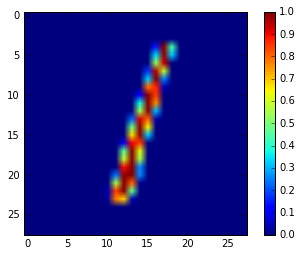

In [92]:
# plt.imshow(new_img.reshape((28, 28)))
# plt.savefig('./cifar_adv/cw/actual_1.png')

fig, ax = plt.subplots()

im = ax.imshow(new_img.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

# plt.savefig('./mnist_adv/7/original.png')

In [93]:
test_y

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [94]:
# Adding an extra dimension

img = np.expand_dims(new_img, axis=0)

In [95]:
img.shape

(1, 28, 28, 1)

In [96]:
# Predicting output on original image

op = predict(sess, env, img)


Predicting
()


In [97]:
print(op)
np.argmax(op, axis=1)

[[-1.2842351  10.42824     1.4004627  -1.5610291   3.0630944  -2.1460145
   0.24728364  3.3212185   0.09893385 -1.5966411 ]]


array([1])

In [115]:
X_adv = make_jsma(sess, env, img, 0, epochs=245)


Making adversarials via JSMA
Done


In [116]:

adv_op = predict(sess, env, X_adv)


Predicting
()


In [117]:
print(adv_op)
np.argmax(adv_op)

[[ 5.1507454   5.099406    1.3792961  -7.630306    2.651152   -7.3476415
   2.1047158   2.7197003   0.62451315 -3.7288878 ]]


0

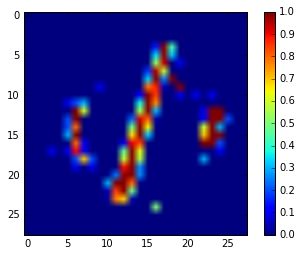

In [119]:
# plt.imshow(xadv.reshape(28, 28))
# plt.savefig('./cifar_adv/cw/actual_1_adv_3.png')

fig, ax = plt.subplots()

im = ax.imshow(X_adv.reshape((28, 28)), cmap='jet')

fig.colorbar(im, ax=ax)

plt.savefig('./mnist_adv/1/jsma-0.png')

In [120]:
diff_img = X_adv - img

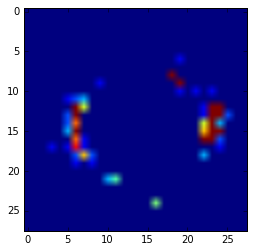

In [121]:
plt.imshow(diff_img.reshape(28, 28))
# plt.savefig('./cifar_adv/cw/diff_1_3.png')